In [10]:
from editor import Editor
from Box2D.b2 import pi

# edit your model by running this cell
# to add a body part hit b and it will spawn under your mouse
# to move body parts drag them with the mouse
# to connect body parts, hit p to pin two bodies at the mouse location
# to change a body part's size, click and hold, then use the arrow keys to modify width/height
# hit 's' to save while editing to model.json

editor = Editor()
editor.load('creatures/stilts2.json')
editor.run()

File saved as: creatures/stilts2.json


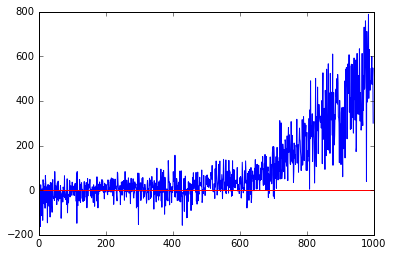

episode: 1000 variance: 1.0 learning_rate: 5e-06


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
import pygame
from pygame.locals import (MOUSEBUTTONDOWN, MOUSEBUTTONUP, KEYDOWN, K_RIGHT, K_LEFT, K_UP, K_DOWN, K_r, K_s)
from Box2D.b2 import pi
from engine import Engine
from time import sleep
import util
import features

# train your model to (hopefully) walk by running this cell

# hit s to speed up training, and s again to watch the best set of weights
# use the up and down arrow keys to introduce more or less randomness in weight changes

# this cell is an experiment with policy improvement
# the agent's joint torques (continuous, action) are randomly sampled from means output by a neural network
# the gradient wrt the weights of that network, for that state, are saved each time step
# if the average reward at the end of an episode is positive, we want the agent to act more like it did
# if the reward was negative we want it to act less like it did that episode

FILE = 'creatures/two_legs.json'

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0

engine = Engine(caption='Train', width=1280, height=720, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, max_torque=10000, \
                linear_damping=0.0, angular_damping=0.0)

# Load creature
engine.load(FILE)

# count joints and body parts
body_count = len(engine.bodies)
joint_count = len(engine.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

def features(time_step=0):
    f = []
    
    for b in engine.bodies:
        a = b.angle % ANGLE_RANGE
        a /= ANGLE_RANGE
        a = a * 2.0 - 1.0
        f += [a]
        f += [np.tanh(b.angularVelocity)]
        #f += [np.tanh(b.linearVelocity[0])]
        f += [np.tanh(b.linearVelocity[1])]
        #f += [np.sin(a)]
        #f += [np.cos(a)]
        f += [engine.to_screen(b.position)[0]/engine.height]
    
    #f += [np.sin(time_step / 2.0)] # Creature's heartbeat? :-)
    #f += [np.cos(time_step / 2.0)]
    #f += [np.sin(time_step)]
    f += [1] # bias
    return np.array([f])

TIMESTEPS = 30 # timesteps per episode
total_r = 0.0
episode = 0
learning_rate = .000005
variance = 3 # increase or decrease deviation from means output by nn
hdim = 32

# tanh:
act = lambda x: np.tanh(x)
act_p = lambda x: 1.0 - np.tanh(x)**2

# rect linear:
#act = lambda x: x * (x > 0)
#act_p = lambda x: (x > 0).astype(np.float)

# soft_plus:
#act = lambda x: np.log(1+np.exp(x))
#act_p = lambda x: np.exp(x)/(1+np.exp(x))

# sparse:
"""
sparsity = 28
def act(x):
    x = x.copy()
    idx = np.argpartition(x, sparsity)[0, :sparsity]
    x[0, idx] = 0
    return x

def act_p(x):
    idx = np.argpartition(x, sparsity)[0, :sparsity]
    mask = np.ones_like(x)
    mask[0, idx] = 0
    return mask
"""

W1 = util.randn([features().shape[1], hdim]) # initial set of weights
W2 = util.randn([hdim + 1, joint_count]) # initial set of weights

rs = []
avg_r = 0

speedup = False
running = True
interacted = False

while running:
    if not interacted:
        rs += [total_r]
        
    if len(rs) >= 100:
        avg_r = np.sum(rs[-100:])/100.0
    
    if episode % 100 == 0:
        clear_output(wait=True)
        
        if len(rs) > 1000:
            rs = rs[-1000:]
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.show()
        
        print('episode: {} variance: {} learning_rate: {}'.format(episode, np.round(variance, 2), learning_rate))
    
    # new episode
    total_r = 0.0
    t = 0
    episode += 1
    
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    engine.set_position((engine.width/2, engine.height/2))
    
    for j in engine.joints:
        j.motorSpeed = np.random.randn()
    
    engine.step_physics(50)
    for b in engine.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
    
    g1 = np.zeros_like(W1)
    g2 = np.zeros_like(W2)
    
    interacted = False
    reset = False
    while not reset:
        engine.clear_screen()
        
        # keyboard input
        engine.update_mouse()
        for event in engine.events():
            if engine.quit_event(event):
                running = False
                reset = True
            if event.type == KEYDOWN:
                k = pygame.key.get_pressed()
                if k[K_UP]:
                    variance += 0.1
                elif k[K_DOWN]:
                    variance -= 0.1
                if k[K_RIGHT]:
                    learning_rate += 0.0001
                elif k[K_LEFT]:
                    learning_rate -= 0.0001
                elif k[K_s]:
                    speedup = not speedup
                    if not speedup:
                        reset = True
                variance = max(variance, 0.0)
            if event.type == MOUSEBUTTONDOWN:
                engine.create_mouse_joint()
                if engine.mouse_joint:
                    interacted = True
            if event.type == MOUSEBUTTONUP:
                engine.destroy_mouse_joint()
        
        engine.update_mouse_joint()
        
        text = 'episode: {} avg reward: {} variance: {}'.format(episode, np.round(avg_r, 2), np.round(variance, 2))
                
        x = features(t)
        z1 = x.dot(W1)
        h1 = act(z1)
        h1 = np.concatenate((h1, np.ones([1, 1])), axis=1)
        z2 = h1.dot(W2)
        h2 = act(z2) * 4
        
        if variance > 0:
            torques = np.array([np.random.normal(loc=u, scale=np.sqrt(variance)) for u in h2[0]])
        else:
            torques = h2[0]
        
        start_p = engine.body_position()
        
        for i, j in enumerate(engine.joints):
            j.motorSpeed = torques[i]
        
        for i in range(10):
            engine.step_physics(1)
            if not speedup:
                engine.clear_screen()
                engine.draw_text(text)
                util.render_matrices(engine.screen, [x.T, W1, h1.T, W2, h2.T, g1, g2])
                engine.render()
                engine.clock_tick()
                
        end_p = engine.body_position()
        
        # reward
        reward = (end_p[0] - start_p[0])
        total_r += reward
                
        util.render_matrix(engine.screen, np.array([[reward]]), (int(end_p[0]), int(end_p[1])))
        
        if abs(end_p[0] - engine.width/2) > 400:
            engine.set_position((engine.width/2, end_p[1]), zero_vel=False)
        
        
        # train
        #r = np.clip(reward-1, -1, 1)
        r = reward
        r = np.clip(r, -10, 10)

        delta = (torques - h2) # /variance
        dz2 = np.multiply(delta, 4 * act_p(z2))
        dh1 = W2.dot(dz2.T).T
        dz1 = np.multiply(dh1[:, :-1], act_p(z1))
        
        g1 += np.multiply(x.T, dz1)
        g2 += np.multiply(h1.T, dz2)

        #g1 = np.clip(g1, -1, 1)
        #g2 = np.clip(g2, -1, 1)
        
        if abs(r) > 8:
            W1 += learning_rate * g1 * r
            W2 += learning_rate * g2 * r

        #W1 *= 0.99998
        #W2 *= 0.99998
        #W1 += randn(W1.shape) * np.abs(g1) * 0.0001
        #W2 += randn(W2.shape) * np.abs(g2) * 0.0001
        #learning_rate *= 0.99996
            
        g1 *= 0.9
        g2 *= 0.9
        
        
        if t > TIMESTEPS and speedup:
            reset = True
            if episode % 10 == 0:
                engine.draw_text(text)
                util.render_matrices(engine.screen, [x.T, W1, h1.T, W2, h2.T, g1, g2])
                engine.render()
        
        #if not speedup:
            #render_matrices([x.T, W1, h1.T, W2, z2.T])
            #engine.render()
            #engine.clock_tick()
            
        t += 1

engine.close()